In [1]:
from pathlib import Path
import pandas as pd
from datetime import datetime
from dateutil import relativedelta

gamma_path = Path('/home/engaclew/neurogen/results/gamma/gamma.csv')
children_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')

gamma = pd.read_csv(gamma_path)
children = pd.read_csv(children_path)
recordings = pd.read_csv(recordings_path)

data = gamma.merge(recordings, left_on='recording_filename', right_on='recording_filename')
data = data.merge(children, left_on='child_id', right_on='child_id', how='right')

# Compute age at time of recording
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month

data['age'] = data.apply(lambda row: diff_month(row), axis=1)
data.loc[data['gamma_cat'] < 0, 'gamma_cat'] = 0
data.loc[data['gamma_chi'] < 0, 'gamma_chi'] = 0
data.loc[data['gamma_och'] < 0, 'gamma_och'] = 0
data.loc[data['gamma_mal'] < 0, 'gamma_mal'] = 0
data.loc[data['gamma_fem'] < 0, 'gamma_fem'] = 0
# excluding them because we have only 2 recordings for these groups
data = data[~data['group_id'].isin(['environmental_risk', 'autism_spectrum_disorder'])]

In [96]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None, offset=0, alpha=1):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh
    barx = [lx+offset, lx+offset, rx-offset, rx-offset]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
    plt.plot(barx, bary, c='black', alpha=alpha)

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
    plt.text(*mid, text, **kwargs, alpha=alpha)

/tmp/ipykernel_23183/1854175253.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(group_label.values()))


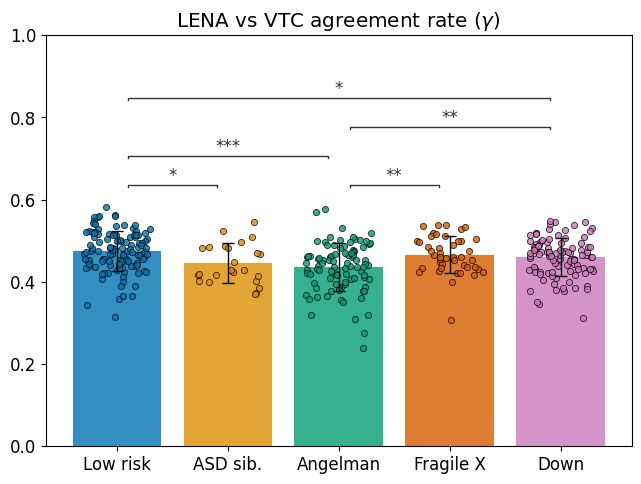

In [106]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
from itertools import combinations

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 12, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1})
cm = 1/2.54

# Sorting data by group
group_label = {
    'low_risk': 'Low risk',
    'autism_sibling': 'ASD sib.',
    #'environmental_risk': 'Env. risks',
    'angelman_syndrome': 'Angelman',
    'fragile_x_syndrome': 'Fragile X',
    'down_syndrome': 'Down',
    #'autism_spectrum_disorder': 'ASD'
}
y_label = {
    'gamma': 'LENA vs VTC agreement rate ($\gamma$)',
    'gamma_cat': 'LENA vs VTC agreement rate ($\gamma_{cat}$)',
    'gamma_chi': 'LENA vs VTC agreement rate ($\gamma_{CHI}$)',
    'gamma_och': 'LENA vs VTC agreement rate ($\gamma_{OCH}$)',
    'gamma_mal': 'LENA vs VTC agreement rate ($\gamma_{MAL}$)',
    'gamma_fem': 'LENA vs VTC agreement rate ($\gamma_{FEM}$)',
}

sorter_index = dict(zip(list(group_label.keys()), range(len(group_label))))
data['group_rank'] = data['group_id'].map(sorter_index)
data.sort_values(by='group_rank', inplace=True)

colors = sns.color_palette('colorblind')[:len(group_label)]
Y_col = 'gamma'
X_col = 'group_id'

fig, ax = plt.subplots(1,1, figsize=(16*cm,12*cm), constrained_layout=True)
X = data[X_col].unique()
Y = data.groupby(X_col)[Y_col].mean()[X]
Yerr = data.groupby(X_col)[Y_col].std(ddof=0)[X]
ax.bar(x=X, height=Y, yerr=Yerr, color=colors, capsize=4, linewidth=2, alpha=.8)
ax.set_xticklabels(list(group_label.values()))
ax.set_title(y_label[Y_col])

# plot scatter
for idx, group_id in enumerate(group_label.keys()):
    sub_data = data[data['group_id'] == group_id]
    X = idx + np.random.uniform(-0.3, 0.3, size=len(sub_data))
    Y = sub_data[Y_col]
    plt.scatter(X,Y, color=colors[idx], edgecolor='black', linewidth=.6, s=20, alpha=.8)
    
# Welch's t-Test to compare the means of two different groups 
# (assume different variances compared to standard t-Test)
plt.ylim(0, 1)
X = data[X_col].unique()
bars = np.arange(len(X))
heights = data.groupby(X_col)[Y_col].mean()[X].values
Yerr = data.groupby(X_col)[Y_col].std(ddof=0)[X].values
grouped_data = data.groupby('group_id')[Y_col].apply(lambda x:x.values)

combinations = [
    # dist = 1
    ('low_risk', 'autism_sibling'), ('autism_sibling', 'angelman_syndrome'), 
    ('angelman_syndrome', 'fragile_x_syndrome'), ('fragile_x_syndrome', 'down_syndrome'),
    # dist = 2
    ('low_risk', 'angelman_syndrome'), ('autism_sibling', 'fragile_x_syndrome'), ('angelman_syndrome', 'down_syndrome'), 
    # dist = 3
    ('low_risk', 'fragile_x_syndrome'), ('autism_sibling', 'down_syndrome'),
    # dist = 4
    ('low_risk', 'down_syndrome')]
cnt_offset = 0
y_offset = .07
for group1, group2 in combinations:
    res = stats.ttest_ind(grouped_data[group1], grouped_data[group2], equal_var=False)
    idx1, idx2 = np.where(X == group1)[0], np.where(X == group2)[0]
    if np.abs(idx1-idx2) == 1 and res.pvalue < .05:
        max_y = data[Y_col].max()
        heights_2 = np.asarray([max_y]*len(X))
        barplot_annotate_brackets(idx1, idx2, res.pvalue, bars, heights_2, dh=.05, barh=0.005, maxasterix=3, offset=.1, alpha=.8)
    elif np.abs(idx1-idx2) > 1 and res.pvalue < .05: 
        cnt_offset += y_offset
        heights_2 = np.asarray([max_y]*len(X)) + cnt_offset
        barplot_annotate_brackets(idx1, idx2, res.pvalue, bars, heights_2, dh=.05, barh=0.005, maxasterix=3, offset=.1, alpha=.8)
plt.savefig(Path('../results/gamma') / f'{Y_col}_per_{X_col}.png')
plt.show()


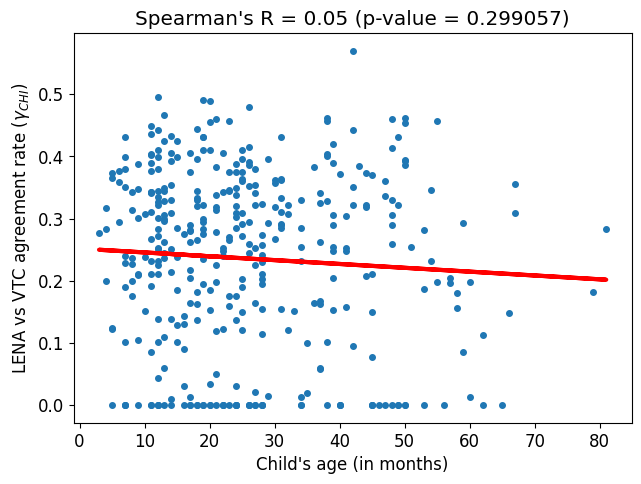

In [110]:
# Analyzing : Y ~ recording duration/age
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

fig, ax = plt.subplots(1,1, figsize=(16*cm,12*cm), constrained_layout=True)

y_label = {
    'gamma': 'LENA vs VTC agreement rate ($\gamma$)',
    'gamma_cat': 'LENA vs VTC agreement rate ($\gamma_{cat}$)',
    'gamma_chi': 'LENA vs VTC agreement rate ($\gamma_{CHI}$)',
    'gamma_och': 'LENA vs VTC agreement rate ($\gamma_{OCH}$)',
    'gamma_mal': 'LENA vs VTC agreement rate ($\gamma_{MAL}$)',
    'gamma_fem': 'LENA vs VTC agreement rate ($\gamma_{FEM}$)',
}


Y_col = 'gamma_chi'
X_col = 'age'

if X_col == 'duration':
    X = data[X_col]/3600000
elif X_col == 'age':
    X = data[X_col]
Y = data[Y_col]
X = X.values.reshape(-1, 1)
Y = Y.values
reg = linear_model.LinearRegression()
reg.fit(X, Y)
Y_pred = reg.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red', linewidth=3)
plt.ylabel(y_label[Y_col])

score = spearmanr(Y, Y_pred)
plt.title("Spearman's R = %.2f (p-value = %f)" % (score.statistic, score.pvalue))

if X_col == "duration":
    plt.xlabel('Recording duration (h)')
    plt.xlim(0,17)
elif X_col == "age":
    plt.xlabel("Child's age (in months)")
plt.savefig(Path('../results/gamma') / f'gamma_{Y_col}_per_{X_col}.png', dpi=300)
plt.show()

In [74]:
set(combinations(group_label.keys(), 2))

{('angelman_syndrome', 'down_syndrome'),
 ('angelman_syndrome', 'fragile_x_syndrome'),
 ('autism_sibling', 'angelman_syndrome'),
 ('autism_sibling', 'down_syndrome'),
 ('autism_sibling', 'fragile_x_syndrome'),
 ('fragile_x_syndrome', 'down_syndrome'),
 ('low_risk', 'angelman_syndrome'),
 ('low_risk', 'autism_sibling'),
 ('low_risk', 'down_syndrome'),
 ('low_risk', 'fragile_x_syndrome')}

333    0.302929
24     0.347785
25     0.277480
26     0.284335
30     0.379875
         ...   
165    0.335932
166    0.334772
156    0.167156
379    0.076335
377    0.304145
Name: gamma_cat, Length: 381, dtype: float64